# CMB simulation and gradient rotation example: T/Q/U

In [15]:
import numpy as np, sys, os, scipy as sc
sys_path_folder='/Users/sraghunathan/Research/SPTPol/analysis/git/cmb_cluster_lensing/python/'
sys.path.append(sys_path_folder)

import flatsky, tools, lensing

from tqdm import tqdm

%load_ext autoreload
%autoreload 2

#%pylab notebook
%matplotlib inline
from pylab import *
cmap = cm.RdYlBu_r

import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
rcParams['figure.dpi'] = 150

In [17]:
paramfile = 'params.ini'
print('\tread/get necessary params')
param_dict = tools.fn_get_param_dict(paramfile)

data_folder = param_dict['data_folder']

#params or supply a params file
dx = param_dict['dx'] #pixel resolution in arcmins
boxsize_am = param_dict['boxsize_am'] #boxsize in arcmins
nx = int(boxsize_am/dx)
mapparams = [nx, nx, dx]
x1,x2 = -nx/2. * dx, nx/2. * dx
verbose = 0
pol = param_dict['pol']
debug = param_dict['debug']
#beam and noise levels
noiseval = param_dict['noiseval'] #uK-arcmin
if pol:
    noiseval = [noiseval, noiseval * np.sqrt(2.), noiseval * np.sqrt(2.)]
beamval = param_dict['beamval'] #arcmins

#CMB power spectrum
cls_file = '%s/%s' %(param_dict['data_folder'], param_dict['cls_file'])

if not pol:
    tqulen = 1
else:
    tqulen = 3
tqu_tit_arr = ['T', 'Q', 'U']


#sim stuffs
total_sim_types = param_dict['total_sim_types'] #unlensed background and lensed clusters
total_clusters = param_dict['total_clusters']
total_randoms = param_dict['total_randoms'] #total_clusters * 10 #much more randoms to ensure we are not dominated by variance in background stack.

#cluster info
cluster_mass = param_dict['cluster_mass']
cluster_z = param_dict['cluster_z']

#cluster mass definitions
delta=param_dict['delta']
rho_def=param_dict['rho_def']
profile_name=param_dict['profile_name']

#cosmology
h=param_dict['h']
omega_m=param_dict['omega_m']
omega_lambda=param_dict['omega_lambda']
z_lss=param_dict['z_lss']
T_cmb=param_dict['T_cmb']

#cutouts specs 
cutout_size_am = param_dict['cutout_size_am'] #arcmins

#for estimating cmb gradient
apply_wiener_filter = param_dict['apply_wiener_filter']
lpf_gradient_filter = param_dict['lpf_gradient_filter']
cutout_size_am_for_grad = param_dict['cutout_size_am_for_grad'] #arcminutes

	read/get necessary params


In [18]:
#get ra, dec or map-pixel grid
ra = np.linspace(x1,x2, nx) #arcmins
dec = np.linspace(x1,x2, nx) #arcmins
ra_grid, dec_grid = np.meshgrid(ra,dec)

In [19]:
#read Cls now
el, dl_tt, dl_ee, dl_bb, dl_te  = np.loadtxt(cls_file, unpack = 1)
dl_all = np.asarray( [dl_tt, dl_ee, dl_bb, dl_te] )
cl_all = tools.dl_to_cl(el, dl_all)
cl_tt, cl_ee, cl_bb, cl_te = cl_all #Cls in uK
cl_dic = {}
cl_dic['TT'], cl_dic['EE'], cl_dic['BB'], cl_dic['TE'] = cl_tt, cl_ee, cl_bb, cl_te
if not pol:
    cl = [cl_tt]    
else:
    cl = cl_all
#loglog(el, cl_tt)
print(len(el))

19899


In [20]:
#get beam and noise
bl = tools.get_bl(beamval, el, make_2d = 1, mapparams = mapparams)
nl_dic = {}
if pol:
    nl = []
    for n in noiseval:
        nl.append( tools.get_nl(n, el) )
    nl = np.asarray( nl )
    nl_dic['T'], nl_dic['P'] = nl[0], nl[1]
else:
    nl = [tools.get_nl(noiseval, el)]
    nl_dic['T'] = nl[0]
print('\tkeys in nl_dict = %s' %(str(nl_dic.keys())))

	keys in nl_dict = dict_keys(['T'])


Text(0.5, 0, 'Multipole $\\ell$')

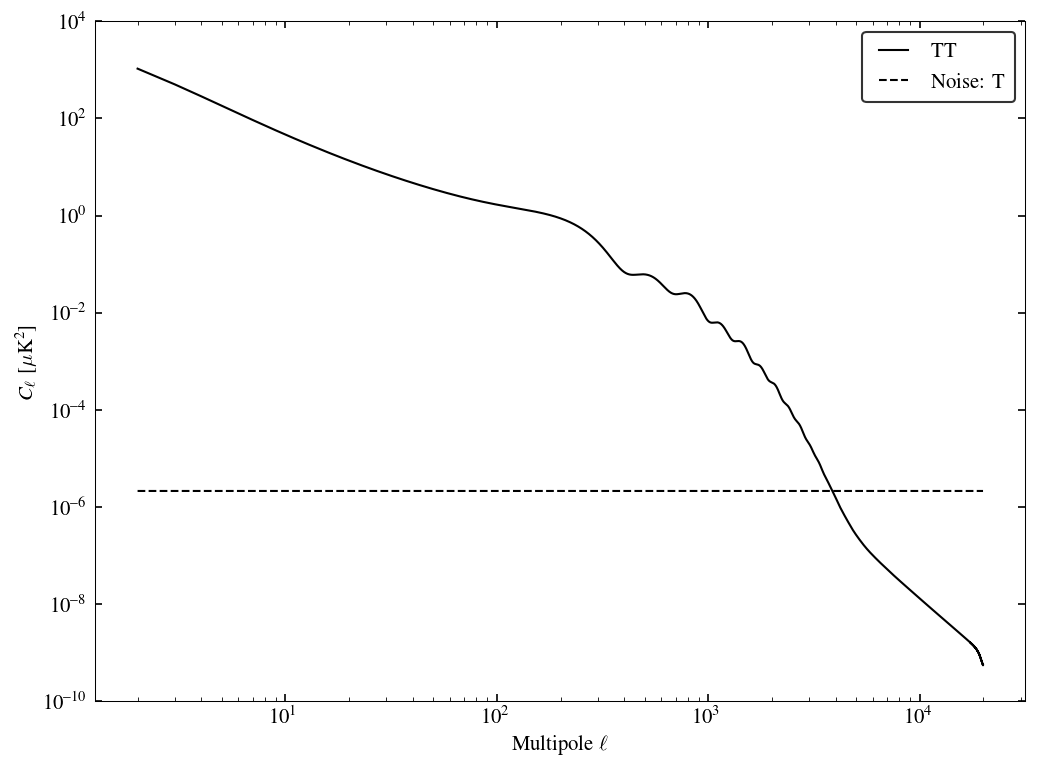

In [21]:
#plot
figure(figsize=(8,6))
ax =subplot(111, yscale = 'log', xscale = 'log')
plot(el, cl[0], color = 'black', label = r'TT')
plot(el, nl[0], color = 'black', ls ='--', label = r'Noise: T')
if pol:
    plot(el, cl[1], color = 'orangered', label = r'EE')
    plot(el, nl[1], color = 'orangered', ls ='--', label = r'Noise: P')
legend(loc = 1)
ylim(1e-10, 1e4)
ylabel(r'$C_{\ell}$ [$\mu$K$^{2}$]')
xlabel(r'Multipole $\ell$')

In [22]:
#NFW lensing convergence
ra_grid_deg, dec_grid_deg = ra_grid/60., dec_grid/60.

M200c_list = np.tile(cluster_mass, total_clusters)
redshift_list = np.tile(cluster_z, total_clusters)
ra_list = dec_list = np.zeros(total_clusters)


kappa_arr = lensing.get_convergence(ra_grid_deg, dec_grid_deg, ra_list, dec_list, M200c_list, redshift_list, param_dict)
print('\tShape of convergence array is %s' %(kappa_arr.shape))

TypeError: not all arguments converted during string formatting

  0%|          | 0/500 [00:00<?, ?it/s]

	creating 500 clusters simulations


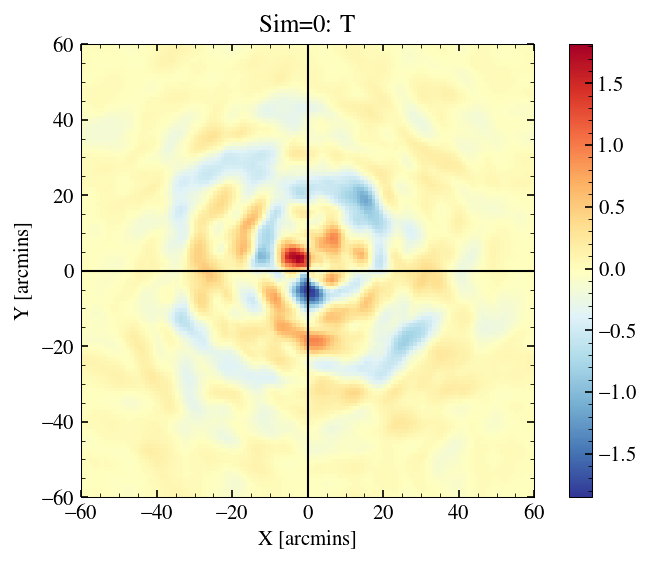

  0%|          | 13/5000 [00:00<00:40, 124.59it/s]

	creating 5000 randoms simulations


100%|██████████| 5000/5000 [00:30<00:00, 163.20it/s]


In [23]:
#perform CMB and noise simulations: unlensed background and lensed clusters
sim_dic = {}
for iter in range( total_sim_types):
    if iter == 0: #cluster lensed sims
        do_lensing = True
        nsims = total_clusters
        sim_type = 'clusters'
    else:
        do_lensing = False        
        nsims = total_randoms        
        sim_type = 'randoms'
    sim_dic[sim_type] = {}
    print('\tcreating %s %s simulations' %(nsims, sim_type))
    sim_arr = []
    for i in tqdm(range(nsims)):
        if not pol:
            cmb_map = np.asarray( [flatsky.make_gaussian_realisation(mapparams, el, cl[0], bl = bl)] )
            noise_map = np.asarray( [flatsky.make_gaussian_realisation(mapparams, el, nl[0])] )
        else:
            cmb_map = flatsky.make_gaussian_realisation(mapparams, el, cl[0], cl2 = cl[1], cl12 = cl[3], bl = bl, qu_or_eb = 'qu')
            noise_map_T = flatsky.make_gaussian_realisation(mapparams, el, nl[0])
            noise_map_Q = flatsky.make_gaussian_realisation(mapparams, el, nl[1])
            noise_map_U = flatsky.make_gaussian_realisation(mapparams, el, nl[1])
            noise_map = np.asarray( [noise_map_T, noise_map_Q, noise_map_U] )
        
        if do_lensing:
            cmb_map_lensed = []
            for tqu in range(tqulen):
                unlensed_cmb = np.copy( cmb_map[tqu] )
                lensed_cmb = lensing.perform_lensing(ra_grid_deg, dec_grid_deg, unlensed_cmb, kappa_arr[i], mapparams)
                if i == 0:
                    subplot(1,tqulen,tqu+1); imshow(lensed_cmb - unlensed_cmb, extent=[x1,x2,x1,x2], cmap=cmap); colorbar(); title(r'Sim=%s: %s' %(i, tqu_tit_arr[tqu])); 
                    axhline(lw = 1.); axvline(lw = 1.); xlabel(r'X [arcmins]'); 
                    if tqu == 0:
                        ylabel(r'Y [arcmins]')
                cmb_map_lensed.append( lensed_cmb )
            if i == 0:
                show()
            cmb_map = np.asarray(cmb_map_lensed)
            
        sim_map = cmb_map + noise_map
        sim_arr.append( sim_map )
    sim_dic[sim_type]['sims'] = np.asarray( sim_arr )

<Figure size 900x600 with 0 Axes>

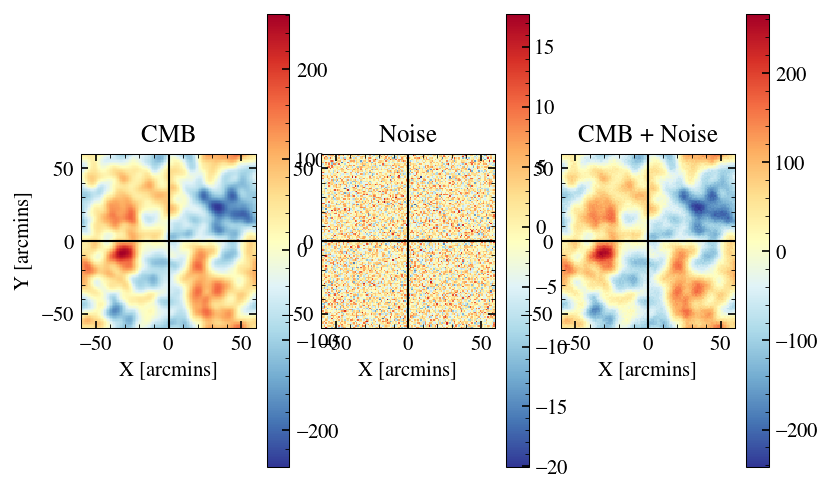

In [24]:
if debug: #just plot the last map
    clf()

    if not pol:
        figure(figsize=(6,4))
        subplots_adjust(hspace=0.2, wspace=0.1)
        subplot(131);imshow(cmb_map[0], extent=[x1,x2,x1,x2], cmap=cmap); colorbar(); title(r'CMB')
        axhline(lw=1.); axvline(lw=1.); xlabel(r'X [arcmins]'); ylabel(r'Y [arcmins]')
        subplot(132);imshow(noise_map[0], extent=[x1,x2,x1,x2], cmap=cmap); colorbar(); title(r'Noise')
        axhline(lw=1.); axvline(lw=1.); xlabel(r'X [arcmins]'); #ylabel(r'Y [arcmins]')
        subplot(133);imshow(sim_map[0], extent=[x1,x2,x1,x2], cmap=cmap); colorbar(); title(r'CMB + Noise')
        axhline(lw=1.); axvline(lw=1.); xlabel(r'X [arcmins]'); #ylabel(r'Y [arcmins]')
    else:
        figure(figsize=(10,10))
        subplots_adjust(hspace=0.2, wspace=0.1)
        for tqucntr in range(tqulen):
            subplot(tqulen,3,(tqucntr*3)+1);imshow(cmb_map[tqucntr], extent=[x1,x2,x1,x2], cmap=cmap); colorbar(); title(r'CMB: %s' %(tqu_tit_arr[tqucntr]))
            axhline(lw=1.); axvline(lw=1.); ylabel(r'Y [arcmins]')
            subplot(tqulen,3,(tqucntr*3)+2);imshow(noise_map[tqucntr], extent=[x1,x2,x1,x2], cmap=cmap); colorbar(); title(r'Noise: %s' %(tqu_tit_arr[tqucntr]))
            axhline(lw=1.); axvline(lw=1.); #xlabel(r'X [arcmins]'); #ylabel(r'Y [arcmins]')
            subplot(tqulen,3,(tqucntr*3)+3);imshow(sim_map[tqucntr], extent=[x1,x2,x1,x2], cmap=cmap); colorbar(); title(r'CMB + Noise: %s' %(tqu_tit_arr[tqucntr]))
            axhline(lw=1.); axvline(lw=1.); xlabel(r'X [arcmins]'); #ylabel(r'Y [arcmins]')
    show()

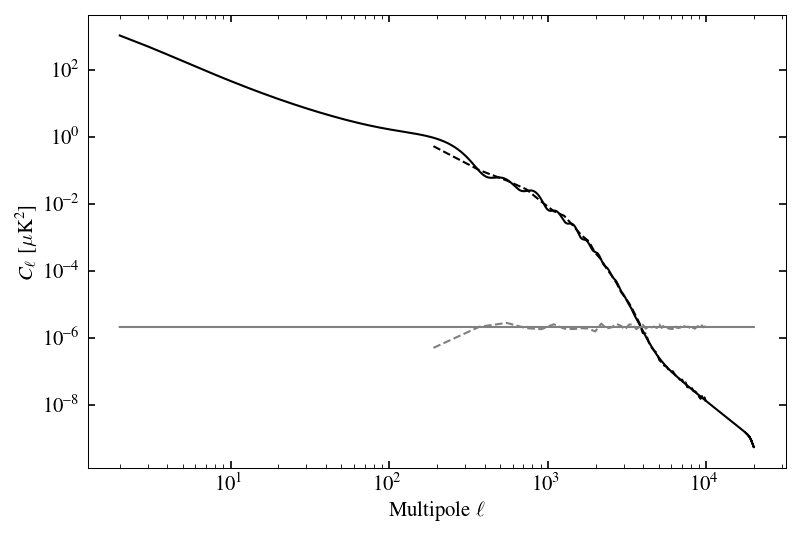

In [25]:
if debug: #get power spectrum of maps to ensure sims are fine
    ax = subplot(111, xscale = 'log', yscale = 'log')
    colorarr = ['black', 'orangered', 'darkgreen']
    colorarr_noise = ['gray', 'crimson', 'lightgreen']
    if pol:
        cl_theory = [cl[0], cl[1]/2, cl[1]/2]
    else:
        cl_theory = [cl[0]]
    for tqucntr in range(tqulen):
        curr_el, curr_cl = flatsky.map2cl(mapparams, cmb_map[tqucntr], filter_2d = bl**2.)
        curr_el, curr_nl = flatsky.map2cl(mapparams, noise_map[tqucntr])

        plot(el, cl_theory[tqucntr], color = colorarr[tqucntr])#, label = r'CMB theory')
        plot(curr_el, curr_cl, color = colorarr[tqucntr], ls ='--')#, label = r'CMB map')
        plot(el, nl[tqucntr], color = colorarr_noise[tqucntr])#, label = r'Noise theory')
        plot(curr_el, curr_nl, color = colorarr_noise[tqucntr], ls ='--')#, label = r'Noise map')

    ylabel(r'$C_{\ell}$ [$\mu$K$^{2}$]')
    xlabel(r'Multipole $\ell$')

In [ ]:
#get gradient information for all cluster cutouts
print('\tget gradient information for all cluster cutouts')
for sim_type in sim_dic:
    sim_arr = sim_dic[sim_type]['sims']
    nsims = len(sim_arr)
    if apply_wiener_filter:
        if pol:
            cl_signal_arr = [cl[0], cl[1], cl[1]]
            cl_noise_arr = [nl[0], nl[1], nl[1]]
        else:
            cl_signal_arr = [cl[0]]
            cl_noise_arr = [nl[0]]

    #get median gradient direction and magnitude for all cluster cutouts + rotate them along median gradient direction.
    ey1, ey2, ex1, ex2 = tools.extract_cutout(mapparams, cutout_size_am)
    
    cutouts_rotated_arr = []
    grad_mag_arr = []
    for i in tqdm(range(nsims)):
        tmp_grad_mag_arr = []
        tmp_cutouts_rotated = []
        for tqu in range(tqulen):
            cutout_grad, grad_orientation, grad_mag = tools.get_gradient(sim_arr[i][tqu], mapparams = mapparams, apply_wiener_filter = apply_wiener_filter, cl_signal = cl_signal_arr[tqu], cl_noise = cl_noise_arr[tqu], lpf_gradient_filter = lpf_gradient_filter, cutout_size_am_for_grad = cutout_size_am_for_grad)

            cutout = sim_arr[i][tqu][ey1:ey2, ex1:ex2]
            cutout_rotated = tools.rotate_cutout( cutout, np.median(grad_orientation) )
            cutout_rotated = cutout_rotated - np.mean(cutout_rotated)

            tmp_cutouts_rotated.append( cutout_rotated )
            tmp_grad_mag_arr.append( np.median(grad_mag) )

        grad_mag_arr.append( np.asarray(tmp_grad_mag_arr) )
        cutouts_rotated_arr.append( np.asarray( tmp_cutouts_rotated ) )

    grad_mag_arr = np.asarray(grad_mag_arr)
    cutouts_rotated_arr = np.asarray(cutouts_rotated_arr)
    print(cutouts_rotated_arr[:, 0].shape)
    print(grad_mag_arr.shape)
    
    sim_dic[sim_type]['cutouts_rotated'] = cutouts_rotated_arr
    sim_dic[sim_type]['grad_mag'] = grad_mag_arr    

  2%|▏         | 12/500 [00:00<00:04, 118.02it/s]

	get gradient information for all cluster cutouts


  0%|          | 22/5000 [00:00<00:23, 214.39it/s]

(500, 10, 10)
(500, 1)


 36%|███▌      | 1809/5000 [00:09<00:14, 217.67it/s]

In [ ]:
#stack rotated cutouts + apply gradient magnitude weights
print('\tstack rotated cutouts + apply gradient magnitude weights')
for sim_type in sim_dic:
    cutouts_rotated_arr = sim_dic[sim_type]['cutouts_rotated']
    grad_mag_arr = sim_dic[sim_type]['grad_mag']

    weighted_stack = np.sum( cutouts_rotated_arr[:, :] * grad_mag_arr[:, :, None, None], axis = 0)
    weights = np.sum( grad_mag_arr, axis = 0)
    stack = weighted_stack / weights[:, None, None]
    print(weighted_stack.shape, weights.shape)
    sim_dic[sim_type]['stack'] = stack

In [ ]:
#plot results

ex1, ex2 = -cutout_size_am/2. * dx, cutout_size_am/2. * dx
cluster_stack = sim_dic['clusters']['stack']
print(cluster_stack.mean())
random_stack = sim_dic['randoms']['stack']
final_stack = cluster_stack - random_stack
sbpl = 1
tr, tc = 3, 3

clf()
figure(figsize=(10,10))
subplots_adjust(hspace = 0.2, wspace = 0.1)
fsval = 10
intrp_val = 'bicubic'

def add_labels(ax, sbpl):
    axhline(lw = 1.); axvline(lw = 1.)
    if sbpl>=7:
        xlabel(r'X [arcmins]')
    if (sbpl-1)%tc == 0: 
        ylabel(r'Y [arcmins]')
    return ax

for tqu in range(tqulen):
    ax = subplot(tr, tc, sbpl); imshow(cluster_stack[tqu], cmap = cmap, extent = [ex1, ex2, ex1, ex2], interpolation = intrp_val); colorbar(); title(r'Cluster stack: %s' %(tqu_tit_arr[tqu]), fontsize = fsval);
    ax = add_labels(ax, sbpl); sbpl+=1
    subplot(tr, tc, sbpl); imshow(random_stack[tqu], cmap = cmap, extent = [ex1, ex2, ex1, ex2], interpolation = intrp_val); colorbar(); title(r'Random stack: %s' %(tqu_tit_arr[tqu]), fontsize = fsval);axhline(lw = 1.); axvline(lw = 1.)
    ax = add_labels(ax, sbpl); sbpl+=1
    subplot(tr, tc, sbpl); imshow(final_stack[tqu], cmap = cmap, extent = [ex1, ex2, ex1, ex2], interpolation = intrp_val); colorbar(); 
    title(r'Lensing stack: %s (%s clusters)' %(tqu_tit_arr[tqu], total_clusters), fontsize = fsval);axhline(lw = 1.); axvline(lw = 1.)
    ax = add_labels(ax, sbpl); sbpl+=1
show()

In [ ]:
#get JK based covariance from cluster cuouts

#BG subtracted rotated cluster cuouts
cluster_cutouts_rotated_arr = np.copy(sim_dic['clusters']['cutouts_rotated']) - random_stack
if (0):
    tmp_stack = np.mean(cluster_cutouts_rotated_arr, axis = 0)
    for tqu in range(len(tmp_stack)):
        subplot(1, 3, tqu+1); imshow(tmp_stack[tqu]); colorbar()
    show(); sys.exit()
cluster_grad_mag_arr = sim_dic['clusters']['grad_mag']

jk_cov = tools.get_jk_covariance(cluster_cutouts_rotated_arr, param_dict['howmany_jk_samples'], weights = cluster_grad_mag_arr, only_T = False)
print(jk_cov.shape)
imshow(jk_cov, cmap = cmap); colorbar(); show()

In [ ]:
'''
op_dic = {}
op_dic['cluster_cutouts_rotated_arr'] = cluster_cutouts_rotated_arr
op_dic['cluster_grad_mag_arr'] = cluster_grad_mag_arr
np.save('tmp_op_20210825_for_cov_check.npy', op_dic)
cluster_grad_mag_arr[:,0].shape
cluster_cutouts_rotated_arr[:,0].shape
'''